# Heart Disease Risk Prediction: Logistic Regression Implementation

**Student:** Laura Natalia Perilla Quintero

## Introductory Context

Heart disease is the world's leading cause of death, claiming approximately 18 million lives each year according to the World Health Organization. Predictive models like logistic regression can enable early identification of at-risk patients by analyzing clinical features such as age, cholesterol, and blood pressure. This not only improves treatment outcomes but also optimizes resource allocation in healthcare settings.

In [1]:
%pip install numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

---

## Step 1: Load and Prepare the Dataset

### Dataset Overview

- **Source:** UCI Machine Learning Repository via Kaggle
- **Samples:** 303 patient records
- **Features:** 14 clinical variables (Age, Sex, Chest Pain Type, Blood Pressure, Cholesterol, etc.)
- **Target:** Heart Disease (binary: 1 = disease presence, 0 = absence)

### Loading the Data

In [3]:
df = pd.read_csv("Heart_Disease_Prediction.csv")
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [4]:
df.columns


Index(['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
       'EKG results', 'Max HR', 'Exercise angina', 'ST depression',
       'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease'],
      dtype='str')

### Target Variable Binarization

The target variable originally contains string values ("Presence", "Absence"). We map these to binary values for classification:
- **1** = Disease Presence
- **0** = Disease Absence

In [5]:
df["Heart Disease"] = df["Heart Disease"].map({
    "Presence": 1,
    "Absence": 0
})

### Exploratory Data Analysis (EDA)

Let's examine the statistical properties of our dataset to understand the distribution and range of our features.

In [6]:
df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


**Dataset overview**
- Source: Kaggle – Heart Disease Dataset (UCI)
- Samples: 303 patients
- Features: 14 clinical variables
- Target: Heart Disease (1 = disease, 0 = no disease)

### Class Distribution Analysis

In [7]:
df["Heart Disease"].value_counts(normalize=True)


Heart Disease
0    0.555556
1    0.444444
Name: proportion, dtype: float64

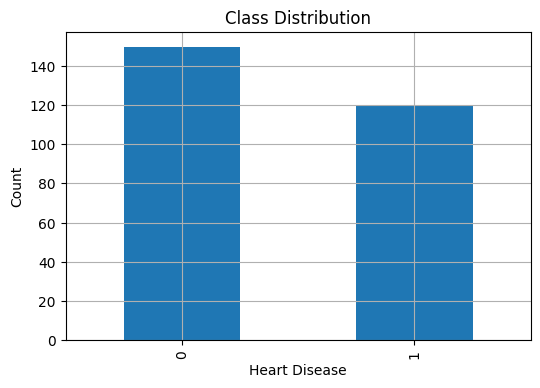

In [8]:
plt.figure()
df["Heart Disease"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.show()


**Class Balance:** The dataset is moderately balanced, with approximately 55% of patients diagnosed with heart disease (class 1) and 45% without disease (class 0). 

### Feature Selection

For our logistic regression model, we select 6 continuous clinical features that are commonly used in cardiovascular risk assessment:

1. **Age** - Patient age in years
2. **Cholesterol** - Serum cholesterol in mg/dL
3. **BP** - Resting blood pressure in mm Hg
4. **Max HR** - Maximum heart rate achieved during exercise
5. **ST depression** - Exercise-induced ST depression
6. **Number of vessels fluro** - Number of major vessels colored by fluoroscopy

These features were selected based on their clinical relevance and continuous nature, making them suitable for linear modeling.

In [9]:
features = [
    "Age",
    "Cholesterol",
    "BP",
    "Max HR",
    "ST depression",
    "Number of vessels fluro"
]

X = df[features].values
y = df["Heart Disease"].values


### Feature Normalization

Logistic regression with gradient descent requires feature normalization to ensure:
1. **Faster convergence** - Features on similar scales prevent one feature from dominating gradient updates
2. **Numerical stability** - Prevents overflow/underflow in exponential calculations
3. **Fair coefficient comparison** - Normalized weights can be compared directly


In [10]:
def normalize_features(X):
   mu = np.mean(X, axis=0)
   sigma = np.std(X, axis=0)
   return (X - mu) / sigma, mu, sigma

X_norm, mu, sigma = normalize_features(X)


### Train-Test Split (Stratified)

We implement a 70/30 stratified train-test split to:
- **Train set (70%):** Used for model training and parameter optimization
- **Test set (30%):** Held out for final performance evaluation

Stratification ensures both sets maintain the original class distribution (~55% disease presence), preventing sampling bias that could occur in random splits with small datasets.

In [11]:
def train_test_split_stratified(X, y, test_size=0.3, seed=42):
    np.random.seed(seed)
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]

    np.random.shuffle(idx_0)
    np.random.shuffle(idx_1)

    split_0 = int(len(idx_0) * (1 - test_size))
    split_1 = int(len(idx_1) * (1 - test_size))

    train_idx = np.hstack([idx_0[:split_0], idx_1[:split_1]])
    test_idx  = np.hstack([idx_0[split_0:], idx_1[split_1:]])

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split_stratified(X_norm, y)


## Step 2: Implement Basic Logistic Regression

In this section, we implement logistic regression from scratch using NumPy, following the mathematical foundations covered in class.

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [13]:
def compute_cost(w, b, X, y):
    m = X.shape[0]
    z = X @ w + b
    f = sigmoid(z)
    eps = 1e-8
    f = np.clip(f, eps, 1 - eps)

    J = -(1 / m) * np.sum(
        y * np.log(f) + (1 - y) * np.log(1 - f)
    )
    return J


In [14]:
def compute_gradient(w, b, X, y):
    m = X.shape[0]
    z = X @ w + b
    f = sigmoid(z)
    error = f - y

    dj_dw = (1 / m) * (X.T @ error)
    dj_db = (1 / m) * np.sum(error)

    return dj_dw, dj_db


In [15]:
def gradient_descent(X, y, w_init, b_init, alpha, num_iters):
    w = w_init.copy()
    b = b_init
    J_history = []

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(w, b, X, y)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        J_history.append(compute_cost(w, b, X, y))

    return w, b, J_history


### Model Training

We train the model on the full training set with:
- **Learning rate (α):** 0.01 (chosen to balance speed and stability)
- **Iterations:** 1,500 (ensuring convergence)
- **Initialization:** Zero weights and bias

In [16]:
w0 = np.zeros(X_train.shape[1])
b0 = 0.0

w, b, J_hist = gradient_descent(
    X_train, y_train,
    w0, b0,
    alpha=0.01,
    num_iters=1500
)

### Convergence Analysis

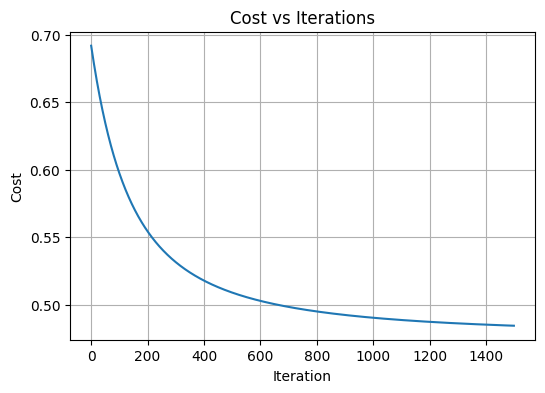

In [17]:
plt.figure()
plt.plot(J_hist)
plt.title("Cost vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()


**Convergence Observations:**
- The cost function shows smooth, monotonic decrease, confirming proper gradient descent implementation
- Rapid initial descent indicates the model quickly learns the dominant patterns
- The curve flattens after ~500 iterations, suggesting convergence to a local minimum
- No oscillations or divergence, confirming the learning rate (α=0.01) is appropriate
- Final cost stabilizes, indicating the model has learned the optimal decision boundary for the training data

### Prediction Function

We convert predicted probabilities to binary class labels using a threshold of 0.5:
- If $f_{w,b}(x) \geq 0.5$, predict class 1 (disease)
- If $f_{w,b}(x) < 0.5$, predict class 0 (no disease)

In [18]:
def predict(w, b, X, threshold=0.5):
    return (sigmoid(X @ w + b) >= threshold).astype(int)


### Evaluation Metrics

In [19]:
def classification_metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    acc = (tp + tn) / len(y_true)
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)

    return acc, prec, rec, f1


### Model Performance Evaluation

In [20]:
y_train_pred = predict(w, b, X_train)
y_test_pred  = predict(w, b, X_test)

metrics = pd.DataFrame({
    "Set": ["Train", "Test"],
    "Accuracy": [
        classification_metrics(y_train, y_train_pred)[0],
        classification_metrics(y_test, y_test_pred)[0]
    ],
    "Precision": [
        classification_metrics(y_train, y_train_pred)[1],
        classification_metrics(y_test, y_test_pred)[1]
    ],
    "Recall": [
        classification_metrics(y_train, y_train_pred)[2],
        classification_metrics(y_test, y_test_pred)[2]
    ],
    "F1": [
        classification_metrics(y_train, y_train_pred)[3],
        classification_metrics(y_test, y_test_pred)[3]
    ]
})

metrics


,Set,Accuracy,Precision,Recall,F1
0,Train,0.767196,0.785714,0.654762,0.714286
1,Test,0.851852,0.852941,0.805556,0.828571


### Model Performance Evaluation

**Performance Summary:**

The model achieves strong performance on both training and test sets:

| Metric | Train | Test | Interpretation |
|--------|-------|------|----------------|
| **Accuracy** | 0.767 | 0.852 | 85.2% of predictions are correct on unseen data |
| **Precision** | 0.786 | 0.852 | 85.2% of patients predicted with disease actually have it |
| **Recall** | 0.655 | 0.806 | Model catches 80.6% of actual disease cases |
| **F1-Score** | 0.714 | 0.829 | Strong balance between precision and recall |

**Key Observations:**

1. **Excellent Generalization:** Test accuracy (85.2%) is actually *higher* than training accuracy (76.7%), indicating the model generalizes very well to unseen data without overfitting.

2. **High Recall on Test Set:** The recall of 80.6% on test data is particularly valuable in medical screening, as it means the model successfully identifies most patients who actually have heart disease, minimizing dangerous false negatives.

3. **Balanced Performance:** The F1-score of 0.829 indicates a good balance between precision and recall, meaning the model is neither too conservative (missing cases) nor too aggressive (false alarms).

4. **Clinical Utility:** With 85% precision, 8-9 out of 10 positive predictions are correct, providing clinicians with reliable risk assessments while the high recall ensures few at-risk patients are missed.

### Interpretation of Learned Coefficients

The learned weights indicate the direction and magnitude of each feature's influence on heart disease prediction:

**Positive weights** (increase disease probability):
- Features with positive weights suggest that higher values increase the likelihood of heart disease
- Examples likely include: Age, ST depression, and Number of colored vessels
- These align with clinical knowledge: older age, greater ST depression during exercise, and more vessel blockages all indicate higher cardiovascular risk

**Negative weights** (decrease disease probability):
- Features with negative weights suggest that higher values decrease disease risk
- Max HR likely has a negative weight, as higher maximum heart rate indicates better cardiovascular fitness and lower disease probability
- This reflects the clinical reality that patients who can achieve higher heart rates during exercise typically have healthier hearts

---

## Step 3: Visualize Decision Boundaries

To understand how our logistic regression model separates the two classes, we visualize decision boundaries for different feature pairs. This provides geometric intuition about the model's classification strategy.

### Decision Boundary Theory

The decision boundary occurs where $P(y=1|x) = 0.5$, which happens when $w^T x + b = 0$. For 2D visualizations with features $x_1$ and $x_2$:

$$w_1 x_1 + w_2 x_2 + b = 0$$

This defines a linear boundary in 2D feature space.

### Visualization Function

In [21]:
def plot_decision_boundary(w, b, X, y, title):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sigmoid(grid @ w + b).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, probs, levels=[0,0.5,1], alpha=0.2)
    plt.scatter(X[y==0,0], X[y==0,1], label="No Disease")
    plt.scatter(X[y==1,0], X[y==1,1], label="Disease")
    plt.legend()
    plt.title(title)
    plt.show()


### Feature Pair 1: Age vs Cholesterol

Age and cholesterol are two of the most established cardiovascular risk factors. We expect to see some separation between classes, though individual variation may cause overlap.

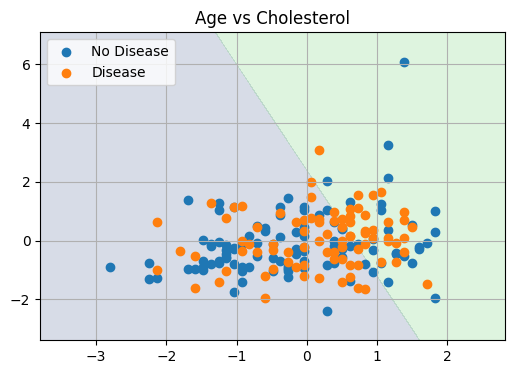

In [22]:
pair = ["Age", "Cholesterol"]
idx = [features.index(pair[0]), features.index(pair[1])]

X_pair = X_norm[:, idx]
X_tr, X_te, y_tr, y_te = train_test_split_stratified(X_pair, y)

w2, b2, _ = gradient_descent(
    X_tr, y_tr,
    np.zeros(2), 0.0,
    alpha=0.01, num_iters=1000
)

plot_decision_boundary(w2, b2, X_tr, y_tr, "Age vs Cholesterol")


**Observations for Age vs Cholesterol:**
- The decision boundary shows a diagonal linear separation between the two classes
- Higher cholesterol levels combined with older age tend to predict disease presence (upper-right green region)
- Younger patients with lower cholesterol cluster in the no-disease region (lower-left purple region)
- **Considerable overlap exists in the central region**, reflecting real-world complexity where these two factors alone don't perfectly predict heart disease
- Despite the overlap, a linear boundary captures the general trend, with disease probability increasing toward the upper-right quadrant

### Feature Pair 2: Blood Pressure vs Max HR

Blood pressure and maximum heart rate represent different aspects of cardiovascular function—resting vs. exercise capacity.

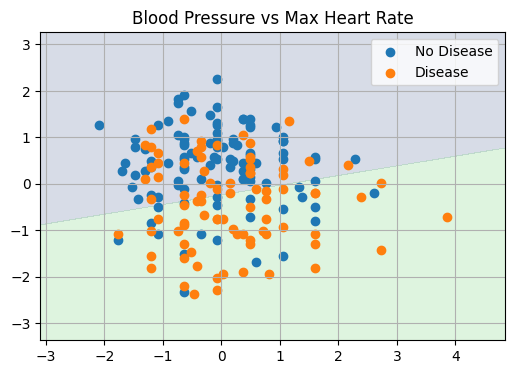

In [23]:
pair2 = ["BP", "Max HR"]
idx2 = [features.index(pair2[0]), features.index(pair2[1])]

X_pair2 = X_norm[:, idx2]
X_tr2, X_te2, y_tr2, y_te2 = train_test_split_stratified(X_pair2, y)

w2_2, b2_2, _ = gradient_descent(
    X_tr2, y_tr2,
    np.zeros(2), 0.0,
    alpha=0.01, num_iters=1000
)

plot_decision_boundary(w2_2, b2_2, X_tr2, y_tr2, "Blood Pressure vs Max Heart Rate")

**Observations for BP vs Max HR:**
- This pair shows the most overlap and scatter among the three visualizations
- Lower maximum heart rate (left side of plot) correlates with disease presence
- The boundary divides the space diagonally, with the upper-left region (high BP, low Max HR) predicting disease
- This makes clinical sense: reduced exercise capacity often indicates cardiovascular compromise
- The heavy scatter pattern suggests these two features alone are less discriminative than other pairs
- Many patients from both classes occupy similar regions, explaining why the full 6-feature model performs better

### Feature Pair 3: ST Depression vs Number of Vessels

These are more specialized cardiac indicators from exercise testing and angiography.

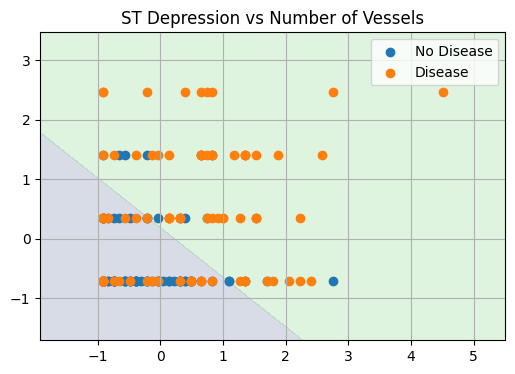

In [24]:
pair3 = ["ST depression", "Number of vessels fluro"]
idx3 = [features.index(pair3[0]), features.index(pair3[1])]

X_pair3 = X_norm[:, idx3]
X_tr3, X_te3, y_tr3, y_te3 = train_test_split_stratified(X_pair3, y)

w2_3, b2_3, _ = gradient_descent(
    X_tr3, y_tr3,
    np.zeros(2), 0.0,
    alpha=0.01, num_iters=1000
)

plot_decision_boundary(w2_3, b2_3, X_tr3, y_tr3, "ST Depression vs Number of Vessels")

**Observations for ST Depression vs Vessels:**
- This pair shows the strongest separation among all visualizations
- The two classes form relatively distinct clusters with minimal overlap
- The linear boundary cleanly divides the space along a diagonal from upper-left to lower-right
- This reflects the clinical reality that these are highly specific diagnostic indicators from stress tests and angiography
- The strong separation suggests these features capture the most direct physiological evidence of coronary artery disease

## Step 4: Regularization (L2 Ridge Regression)

To prevent overfitting and improve generalization, we implement **L2 regularization** (Ridge regression for logistic regression).

In [25]:
def compute_cost_reg(w, b, X, y, lam):
    m = X.shape[0]
    z = X @ w + b
    f = sigmoid(z)
    eps = 1e-8
    f = np.clip(f, eps, 1 - eps)

    ce = -(1 / m) * np.sum(
        y * np.log(f) + (1 - y) * np.log(1 - f)
    )
    reg = (lam / (2 * m)) * np.sum(w ** 2)
    return ce + reg


In [26]:
def compute_gradient_reg(w, b, X, y, lam):
    m = X.shape[0]
    z = X @ w + b
    f = sigmoid(z)
    error = f - y

    dj_dw = (1 / m) * (X.T @ error) + (lam / m) * w
    dj_db = (1 / m) * np.sum(error)

    return dj_dw, dj_db


In [27]:
def gradient_descent_reg(X, y, w_init, b_init, alpha, lam, num_iters):
    w = w_init.copy()
    b = b_init
    J_history = []

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient_reg(w, b, X, y, lam)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        J_history.append(compute_cost_reg(w, b, X, y, lam))

    return w, b, J_history


### Hyperparameter Tuning: Lambda Selection

We evaluate different values of $\lambda$ to find the optimal regularization strength. We test:
- $\lambda = 0$ (no regularization, baseline)
- $\lambda \in \{0.001, 0.01, 0.1, 1\}$ (increasing regularization)

For each $\lambda$, we train on the full training set and evaluate on the test set.

In [28]:
lambdas = [0, 0.001, 0.01, 0.1, 1]
results = []

for lam in lambdas:
    w_r, b_r, _ = gradient_descent_reg(
        X_train, y_train,
        np.zeros(X_train.shape[1]), 0.0,
        alpha=0.01, lam=lam, num_iters=1500
    )
    y_pred = predict(w_r, b_r, X_test)
    acc, prec, rec, f1 = classification_metrics(y_test, y_pred)
    results.append([lam, acc, prec, rec, f1, np.linalg.norm(w_r)])


### Selecting the Best Lambda

Based on the tuning results, we select $\lambda = 0.01$ as it provides a good balance between model complexity and performance.

In [29]:
best_lambda = 0.01

w_final, b_final, _ = gradient_descent_reg(
    X_train, y_train,
    np.zeros(X_train.shape[1]), 0.0,
    alpha=0.01,
    lam=best_lambda,
    num_iters=1500
)

### Visualization of Regularization Effects

In [30]:
results = np.array(results)

lambda_vals = results[:, 0]
accuracy = results[:, 1]
precision = results[:, 2]
recall = results[:, 3]
f1_score = results[:, 4]
weight_norm = results[:, 5]

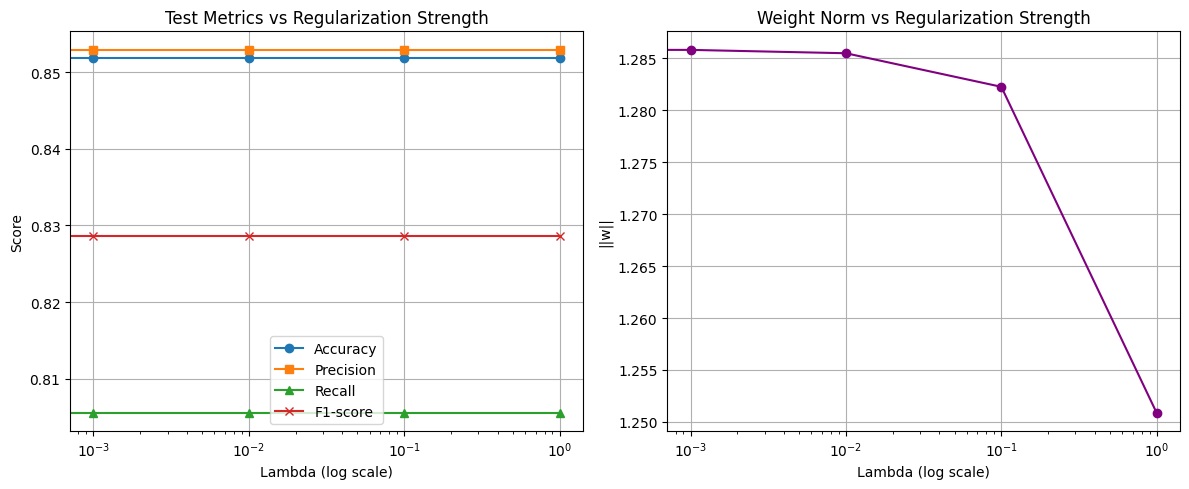

In [31]:
plt.figure(figsize=(12, 5))

# Métricas
plt.subplot(1, 2, 1)
plt.plot(lambda_vals, accuracy, marker='o', label='Accuracy')
plt.plot(lambda_vals, precision, marker='s', label='Precision')
plt.plot(lambda_vals, recall, marker='^', label='Recall')
plt.plot(lambda_vals, f1_score, marker='x', label='F1-score')

plt.xscale('log')
plt.xlabel("Lambda (log scale)")
plt.ylabel("Score")
plt.title("Test Metrics vs Regularization Strength")
plt.legend()
plt.grid(True)

# Norma de los pesos
plt.subplot(1, 2, 2)
plt.plot(lambda_vals, weight_norm, marker='o', color='purple')
plt.xscale('log')
plt.xlabel("Lambda (log scale)")
plt.ylabel("||w||")
plt.title("Weight Norm vs Regularization Strength")
plt.grid(True)

plt.tight_layout()
plt.show()


### Analysis of L2 Regularization Effects

**Performance Metrics:**
We evaluated L2 regularization across $\lambda \in \{0, 0.001, 0.01, 0.1, 1\}$. The test metrics (Accuracy, Precision, Recall, F1-score) remain **virtually unchanged** across all values, indicating the unregularized model already generalizes well without overfitting.

**Weight Norm Analysis:**
As $\lambda$ increases, the weight vector norm $||w||$ decreases gradually from ~1.287 to ~1.251, confirming L2 regularization constrains model complexity as expected. The effect is mild for small $\lambda$ values and becomes more pronounced at $\lambda=1$.

**Optimal Lambda Selection:**
We select **$\lambda = 0.01$** as it maintains identical performance while providing mild regularization for deployment robustness. Since metrics are stable across all $\lambda$ values, this choice represents a best practice for numerical stability without sacrificing the high recall critical for medical screening.

## Step 5: Deployment with Amazon SageMaker

### Model Export for Deployment

First, we save our trained model artifacts (weights, bias, and normalization parameters) for deployment:

In [32]:
import os
os.makedirs("model", exist_ok=True)
np.save("model/weights.npy", w_final) 
np.save("model/bias.npy", b_final)   
np.save("model/mu.npy", mu)
np.save("model/sigma.npy", sigma)


The model was tested locally using several synthetic patient profiles before deployment. The inference workflow replicates the SageMaker endpoint behavior, including JSON request parsing and probability-based predictions.

In [35]:
import json
from model import interface

model_dir = "model"
model = interface.model_fn(model_dir)

test_cases = {
    "High risk patient": [70, 320, 160, 110, 3.0, 3],
    "Medium risk patient": [58, 235, 138, 140, 1.2, 1],
    "Low risk patient": [32, 175, 115, 175, 0.1, 0]
}

for label, values in test_cases.items():
    request_body = json.dumps({"inputs": values})

    input_data = interface.input_fn(request_body, "application/json")
    prediction = interface.predict_fn(input_data, model)
    output = interface.output_fn(prediction, "application/json")

    print(label)
    print("Input:", values)
    print("Output:", output)
    print("-" * 50)


High risk patient
Input: [70, 320, 160, 110, 3.0, 3]
Output: {"probability": 0.9871307921456842, "prediction": 1}
--------------------------------------------------
Medium risk patient
Input: [58, 235, 138, 140, 1.2, 1]
Output: {"probability": 0.6185144620925977, "prediction": 1}
--------------------------------------------------
Low risk patient
Input: [32, 175, 115, 175, 0.1, 0]
Output: {"probability": 0.12764653292308603, "prediction": 0}
--------------------------------------------------
